# Import

In [3]:
import numpy as np
import time
import matplotlib
import itertools
# matplotlib.use("Agg")
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook
import cv2
from skimage.morphology import skeletonize

import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import math
from scipy import interpolate
from scipy import integrate
import os

import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
file_paths = ["../predictions/20201119/bottomup/pred_FishTank20200416_160648/results/FishTank20200416_160648/FishTank20200416_160648.h5",
              "../predictions/20201119/bottomup/pred_FishTank20200413_154621/results/FishTank20200413_154621/FishTank20200413_154621.h5",
              "../predictions/20201120/pred_FishTank20200414_154100/results/FishTank20200414_154100/FishTank20200414_154100.h5",
              "../predictions/20201120/pred_FishTank20200415_154234/results/FishTank20200415_154234/FishTank20200415_154234.h5",
              "../predictions/20201120/pred_FishTank20200417_154139/results/FishTank20200417_154139/FishTank20200417_154139.h5",
              "../predictions/20201120/pred_FishTank20200418_160144/results/FishTank20200418_160144/FishTank20200418_160144.h5",
              "../predictions/20201120/pred_FishTank20200419_151352/results/FishTank20200419_151352/FishTank20200419_151352.h5",
              "../predictions/20201120/pred_FishTank20200419_173651/results/FishTank20200419_173651/FishTank20200419_173651.h5",
              "../predictions/20201120/pred_FishTank20200420_153056/results/FishTank20200420_153056/FishTank20200420_153056.h5",
              "../predictions/20201120/pred_FishTank20200420_175237/results/FishTank20200420_175237/FishTank20200420_175237.h5",
             ]

# All data variables
speeds_frametoframe = []
data_3D_filtered = []
angles_upperbody_360 = []
angles_upperbody_180 = []
upperbody_angles_xy = []
upperbody_angles_z = []
tail_angles_xy = []
tail_angles_z = []
speed_xyz = []
speed_upperbody_angles_xy = []
speed_upperbody_angles_z = []
speed_tail_angles_xy = []
speed_tail_angles_z = []
data_3D = []
original_instances = []

for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        original_instances.append(np.copy(f['original_instances']))
        data_3D.append(np.copy(f['tracks_3D']))
        speeds_frametoframe.append(np.copy(f['speed_frametoframe']))
        data_3D_filtered.append(np.copy(f['tracks_3D_no_outliers_60']))
        angles_upperbody_360.append(np.copy(f['upperbody_xy_angle_0to360']))
        angles_upperbody_180.append(np.copy(f['upperbody_xy_angle_180']))
        upperbody_angles_xy.append(np.copy(f['upperbody_xy_angle_additive']))
        upperbody_angles_z.append(np.copy(f['upperbody_z_angle']))
        tail_angles_xy.append(np.copy(f['tail_xy_angle']))
        tail_angles_z.append(np.copy(f['tail_z_angle']))
        speed_xyz.append(np.copy(f['speed_xyz']))
        speed_upperbody_angles_xy.append(np.copy(f['speed_upperbody_angles_xy']))
        speed_upperbody_angles_z.append(np.copy(f['speed_upperbody_angles_z']))
        speed_tail_angles_xy.append(np.copy(f['speed_tail_angles_xy']))
        speed_tail_angles_z.append(np.copy(f['speed_tail_angles_z']))
        
# relation to fishpair image tatsuo
fishpairs=["9_top",
           "7_down",
           "7_up",
           "9_down",
           "10_down",
           "10_up",
           "8_down",
           "6_down",
           "8_up",
           "6_up"
          ]

# Functions used in full experiment function

In [10]:
def threshold_maker(img):
    #threshold filters
    kernel = np.ones((3,3), np.uint8)
    blurred = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
    erosed = cv2.erode(blurred, kernel, iterations=1) 
    dilated = cv2.dilate(erosed, kernel, iterations=1)
    round_frame = np.around(dilated[:,:,0]/255,1)
    dilated[round_frame > -0.1] = np.nan
    ret,thresh = cv2.threshold(dilated,0,1,cv2.THRESH_BINARY_INV)
    
    return thresh[:,:,0]

def distance(x1,y1,x2,y2):
    d = np.sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))
    return d

def all_distances(x,y):
    starts=[]
    end=0
    distances=[]
    for i in range(len(y)):
        dist = [distance(x[i],y[i],x[j],y[j]) for j in range(len(y))]
        distances.append(dist)
        if len([j for j in dist if j < 1.5]) < 3:
            starts.append(i)
    return starts, distances

def next_step(routes, distances, route_i):
    '''
    recursive function to find different routes
    '''
    
    # end of routes
    if route_i >= len(routes):
        return routes, route_i
    else:
        # find close steps to route 
        val = routes[route_i][-1]
        max_val = 1.5
        min_val = 0
        next_val = [i for i, j in enumerate(distances[val]) if j < max_val and i not in list(itertools.chain(*routes))]

        while next_val == [] and min_val < max_val:
            min_val = min([i for i in distances[val] if i>min_val])
            next_val = [i for i, j in enumerate(distances[val]) if j == min_val and i not in list(itertools.chain(*routes))]
    
        if min_val>max_val:
            next_val = []
        
        # go to next route in list if at end of route
        if next_val == []:
            routes, route_i = next_step(routes, distances, route_i + 1)
        
        # end if at end of routes
        if route_i >= len(routes):
            return routes, route_i
        # add more routes if found and continue in same route
        else:
            if len(next_val) > 1:
                for i in range(1, len(next_val)):
                    routes.append(routes[route_i] + [next_val[i]])

            routes[route_i].append(next_val[0])
            routes, route_i = next_step(routes, distances, route_i)

    return routes, route_i

def find_route(x,y,head):
    starts, distances = all_distances(x,y)
    
    # find start closest to head
    start = starts[np.argmin(np.array([distance(x[i],y[i],head[0],head[1]) for i in starts]))]
    
    routes, _ = next_step([[start]], distances, 0)
    
    return routes
    
def parameters_eucl(k, dist):
    if k == 0:
        return 0
    else:
        return sum(dist[0:k])/sum(dist)

def select_route(routes,tailpoint):
    # remove routes that end at pectoral fins
    
    while True:
        for i in range(len(routes)):
            if tailpoint not in routes[i]:
                routes.pop(i)
                break
        break
        
    min_val = np.argmin(np.array([len(i) for i in routes]))
    max_val = np.argmax(np.array([len(i) for i in routes]))
    while len(routes[max_val]) - len(routes[min_val]) > 10 and len(routes) > 1:
        routes.pop(min_val)
        min_val = np.argmin(np.array([len(i) for i in routes]))
        max_val = np.argmax(np.array([len(i) for i in routes]))
        
    # take shortest route ("the most straight")
    route1 = routes[min_val]
    
    # look for a second route that might go along the other end of the tailfin
    while route1[-1] == routes[min_val][-1] and len(routes) > 1:
        routes.pop(min_val)
        min_val = np.argmin(np.array([len(i) for i in routes]))
    
    # return route1 if no second route (!might improve here)
    if route1[-1] == routes[min_val][-1]:
        return [route1]
    else:
        counter = 0
        for i in reversed(routes[min_val]):
            counter += 1
            if i in route1:
                a = route1.index(i) + 2
                break
            if counter > 10:
                return [route1[:-2]]
            
    return [route1[:a]]

def average_background(video, vid_range=None):
    vidcap = cv2.VideoCapture(video)
    success,image = vidcap.read()
    count = 0
    sum_images = image * 0

    while success:
        
        if vid_range == None:
            sum_images = sum_images.__add__(image/255)
        elif count >= vid_range - 100 and count <= vid_range + 100:
            sum_images = sum_images.__add__(image/255)
        elif count > vid_range + 100:
            break
            
        count += 1
        success,image = vidcap.read()
        
    return sum_images/count*255

def interpolate_equally(x, y, N, bdypts, view, zone_specific=False):
    
    # sort dots from front to end
    head = bdypts[0]
    routes = find_route(x,y,head)
    rts = np.copy(routes)
    
    if np.isnan(bdypts[2][0]):
        bdypts[2] = bdypts[0]
    
    # select route by tail and length
    min_taildist = 100
    for i in range(len(x)):
        taildist = distance(x[i],y[i],bdypts[2][0],bdypts[2][1])
        if taildist < min_taildist:
            min_taildist = taildist
            tailpoint = i
    routeminlen = select_route(routes,tailpoint)
    route = routeminlen[0]
    
    # sort
    sorted_values = [[y[i] for i in route], [x[i] for i in route]]
    
    # filter past headpoint
    distances_head = [distance(sorted_values[1][i], sorted_values[0][i], bdypts[0][0],
                               bdypts[0][1]) for i in range(len(sorted_values[0]))]
    
    index_min_headdist = distances_head.index(min(distances_head))
    if (distance(sorted_values[1][index_min_headdist], sorted_values[0][index_min_headdist],
                sorted_values[1][index_min_headdist + 1], 
                sorted_values[0][index_min_headdist + 1]) > 
        distance(bdypts[0][0], bdypts[0][1],sorted_values[1][index_min_headdist + 1], 
                 sorted_values[0][index_min_headdist + 1])):
        position_head = 1
    else:
        position_head = 0
        
    sorted_values[0] = sorted_values[0][index_min_headdist:-1]
    sorted_values[1] = sorted_values[1][index_min_headdist:-1]
    sorted_values[0].insert(position_head, bdypts[0][1])
    sorted_values[1].insert(position_head, bdypts[0][0])
    
    # distances with bodypoints
    distances_thorax = [distance(sorted_values[1][i], sorted_values[0][i], bdypts[1][0],
                                 bdypts[1][1]) for i in range(len(sorted_values[0]))]
    
    index_min_thoraxdist = distances_thorax.index(min(distances_thorax))
    
    distances_tail = [distance(sorted_values[1][i], sorted_values[0][i], bdypts[2][0],
                               bdypts[2][1]) for i in range(len(sorted_values[0]))]
    
    index_min_taildist = distances_tail.index(min(distances_tail))
    
    # calculate parameters and interpolate
    dist = [distance(sorted_values[1][i],sorted_values[0][i],sorted_values[1][i+1],
                     sorted_values[0][i+1]) for i in range(len(sorted_values[0])-1)]
    parameters = [parameters_eucl(i,dist) for i in range(len(sorted_values[0]))]
    
    # place of thorax and tail
    par_minth = parameters[index_min_thoraxdist]
    par_mintl = parameters[index_min_taildist]
    
    # decide curvature
    if view == 1:
        s_i = 7
    else:
        s_i = 1000
    
    pnew = np.linspace(0, 1, num=1000, endpoint=True)
    tck_x = interpolate.splrep(parameters, sorted_values[1], s=s_i)
    f_x = interpolate.splev(pnew, tck_x, der=0)
    tck_y = interpolate.splrep(parameters, sorted_values[0], s=s_i)
    f_y = interpolate.splev(pnew, tck_y, der=0)
    dist2 = [distance(f_x[i],f_y[i],f_x[i+1],f_y[i+1]) for i in range(len(f_x)-1)]
    
    # now find equally spaced points on the interpolated curve
    total_len = sum(dist2)
    
    equal_x = [f_x[0]]
    equal_y = [f_y[0]]
    part_len = 0
    for i in range(len(pnew)-1):
        part_len += np.sqrt(math.pow(np.diff(f_x)[i],2)+math.pow(np.diff(f_y)[i],2))
        
        if zone_specific:
            if len(equal_x) < 5:
                factor = par_minth
                N_part = N * 0.25 - .7
            elif len(equal_x) < 17:
                factor = par_mintl - par_minth
                N_part = N * 0.6
            else:
                factor = 1 - par_mintl
                N_part = N * 0.15
        else:
            N_part = N-1
            factor = 1

        if part_len >= total_len*factor/(N_part):
            part_len = 0
            equal_x.append(f_x[i])
            equal_y.append(f_y[i])
    
        if len(equal_x) >= 20:
            print("stopped")
            break
            
    if len(equal_x) < 20:
        equal_x.append(f_x[i])
        equal_y.append(f_y[i])
        
    return equal_x, equal_y, [f_x,f_y,rts]

# Full experiment function

In [11]:
def data_gather_experiment(experiment, points, view, filename):
    '''
    Loops over videos, then over frames, and creates the spine model.
    
    INPUT:
    experiment: path to experiment videos
    points: number of points on spine (N)
    view: 0(xz), 1(xy) or 2(yz)
    filename: name where to save data
    
    OUTPUT:
    spinepoints entire experiment
    '''
    
    # save file directly as csv
    with open(filename+'.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        
        videos = sorted([i for i in os.listdir(experiment) if ".mp4" in i and i[0] == 's'])
        t0 = time.time()
        count=0
        
        # loop over videos
        for video in videos:
            
            print(video)
                
            spine_points = []
            
            ti = time.time()

            # calculate background average
            background = average_background(experiment + video)
            
            # loop over frames 
            vidcap = cv2.VideoCapture(experiment + video)
            success,image = vidcap.read()
            while success:
                thorax_xy = original_instances[0][view][count][0][1]
                if np.any(np.isnan(thorax_xy)):
                    spine_points.append([])
                else:
                    image_sub = image - background
                    img = (image_sub[int(thorax_xy[1])-100:int(thorax_xy[1])+100,int(thorax_xy[0])-100:int(thorax_xy[0])+100])
                    skeleton = skeletonize(threshold_maker(img))

                    #spine
                    values = np.where(skeleton==True)
                    tail = [original_instances[0][view][count][0][2][0]-thorax_xy[0]+100, original_instances[0][view][count][0][2][1]-thorax_xy[1]+100]
                    head = [original_instances[0][view][count][0][0][0]-thorax_xy[0]+100, original_instances[0][view][count][0][0][1]-thorax_xy[1]+100]
                    thorax = [100,100]

                    try:
                        xequal, yequal, rest = interpolate_equally(values[1],values[0],points,
                                                                   [head,thorax,tail], view)
                        spine_points.append([xequal,yequal])
                    except:
                        spine_points.append([])

                count += 1
                success,image = vidcap.read()
            
            writer.writerows(spine_points)
            print(time.time()-ti)

        print(time.time()-t0)
    
    return spine_points

# Run spinefitter

## Total

In [7]:
spinepoints20_xy = data_gather_experiment('/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/E_xy/', 20, 1, "spinexy_points20_2")

splitdata0007.mp4


/home/thomasreus/Documents/Project/sleap_env/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
282.545907497406
splitdata0008.mp4
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
293.62589597702026
splitdata0009.mp4
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped


In [8]:
spinepoints20_xz = data_gather_experiment('/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/D_xz/', 20, 0, "spinexz_points20_2")

splitdata0007.mp4
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stoppe

In [9]:
spinepoints20_yz = data_gather_experiment('/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/F_yz/', 20, 2, "spineyz_points20_2")

splitdata0007.mp4
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stopped
stoppe

## Test

In [7]:
# calculate background average
video_007_xy = '/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/E_xy/splitdata0007.mp4'
background_xy = average_background(video_007_xy)

# # calculate background average
# video_007_xz = '/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/D_xz/splitdata0007.mp4'
# background_xz = average_background(video_007_xz)

# video_007_yz = '/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/F_yz/splitdata0007.mp4'
# background_yz = average_background(video_007_yz)

<IPython.core.display.Javascript object>


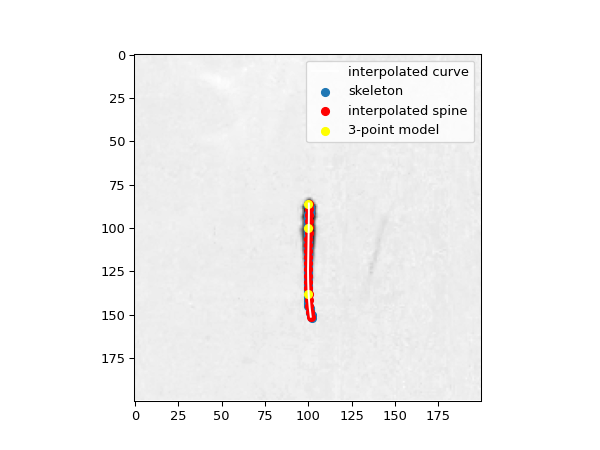

In [14]:
# show images for one frame
frame = 1200

num = 100

vidcap_1 = cv2.VideoCapture(video_007_xy)
# vidcap_2 = cv2.VideoCapture(video_007_xz)
# vidcap_3 = cv2.VideoCapture(video_007_yz)

succes1,image1 = vidcap_1.read()
# succes2,image2 = vidcap_2.read()
# succes3,image3 = vidcap_3.read()

count = 0

while count < frame:
    count += 1
    succes1,image_1 = vidcap_1.read()
#     succes2,image_2 = vidcap_2.read()
#     succes3,image_3 = vidcap_3.read()

thorax_1 = original_instances[0][1][count][0][1]
# thorax_2 = original_instances[0][0][count][0][1]
# thorax_3 = original_instances[0][2][count][0][1]
image1 = image_1 - background_xy
# image2 = image_2 - background_xz
# image3 = image_3 - background_yz
img1 = (image1[int(thorax_1[1])-num:int(thorax_1[1])+num,int(thorax_1[0])-num:int(thorax_1[0])+num])
# img2 = (image2[int(thorax_2[1])-num:int(thorax_2[1])+num,int(thorax_2[0])-num:int(thorax_2[0])+num])
# img3 = (image3[int(thorax_3[1])-num:int(thorax_3[1])+num,int(thorax_3[0])-num:int(thorax_3[0])+num])

# spine
skeleton = skeletonize(threshold_maker(img1))
values = np.where(skeleton==True)
tail = [original_instances[0][1][count][0][2][0]-thorax_1[0]+num, original_instances[0][1][count][0][2][1]-thorax_1[1]+num]
head = [original_instances[0][1][count][0][0][0]-thorax_1[0]+num, original_instances[0][1][count][0][0][1]-thorax_1[1]+num]
thorax = [num,num] 
xequal, yequal, rest = interpolate_equally(values[1],values[0],20,[head,thorax,tail],1)

# plot image
plt.figure()
plt.imshow(img1[:,:,0],cmap='gray')
plt.scatter(values[1],values[0],label='skeleton')
plt.scatter(xequal,yequal,c='red', label='interpolated spine')
plt.scatter(head[0],head[1],label='3-point model',c='yellow')
plt.plot(rest[0], rest[1],label='interpolated curve',c='white')
plt.scatter(tail[0],tail[1],c='yellow')
plt.scatter(thorax[0],thorax[1],c='yellow')
plt.legend()        
plt.show()

## Make a video

In [ ]:
#make a video

Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, metadata=dict(artist='LOS'), bitrate=3500)
t0 = time.time()
fig = plt.figure()

with writer.saving(fig, 'spine007_yz_tailpoint.mp4', 100):
    
    spine_points = []
    video_007 = '/home/thomasreus/Documents/zebrafish_labeling_GUI/OneFish_20200416/F_yz/splitdata0007.mp4'
    # calculate background average
    background = average_background(video_007)
    
    vidcap = cv2.VideoCapture(video_007)
    success,image = vidcap.read()
    count = 0

    while success:
        thorax_xy = original_instances[0][2][count][0][1]
        
        if np.any(np.isnan(thorax_xy)):
            count += 1
            success,image = vidcap.read()
            continue
            
        image_sub = image - background
        img = (image_sub[int(thorax_xy[1])-100:int(thorax_xy[1])+100,int(thorax_xy[0])-100:int(thorax_xy[0])+100])
        skeleton = skeletonize(threshold_maker(img))

        #normal image
        plt.imshow(img[:,:,0],cmap='gray')

        #spine
        values = np.where(skeleton==True)
        tail = [original_instances[0][2][count][0][2][0]-thorax_xy[0]+100, original_instances[0][2][count][0][2][1]-thorax_xy[1]+100]
        head = [original_instances[0][2][count][0][0][0]-thorax_xy[0]+100, original_instances[0][2][count][0][0][1]-thorax_xy[1]+100]
        thorax = [100,100]
        xequal, yequal, rest = interpolate_equally(values[1],values[0],20,[head,thorax,tail],view)
        spine_points.append([xequal,yequal])
        plt.scatter(values[1],values[0],c='blue',label='skeleton')
        plt.plot(xequal,yequal,c='red',label='spine')
        plt.legend()
        
        #3-point model
#         plt.scatter(head[0],head[1],color='white',s=25)
#         plt.scatter(thorax[0],thorax[1],color='white',s=25)
#         plt.scatter(tail[0],tail[1],color='white',s=25)
        
        # add frame to video
        writer.grab_frame()
        
        fig.clear(True)
        
        count += 1
        success,image = vidcap.read()
        
print(time.time()-t0)